In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import logging
from time import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import random
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from scipy.special import softmax
from torch.utils.data import DataLoader
import scipy

In [ ]:
df_goog = pd.read_csv("GOOG.csv", sep="	")
df_aapl = pd.read_csv("AAPL.csv", sep="	")
df_aapl

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.601469
1,2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.647457
2,2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.223597
3,2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.175119
4,2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.349140
...,...,...,...,...,...,...,...
2259,2018-12-24,151.550003,146.589996,148.149994,146.830002,37169200.0,144.656540
2260,2018-12-26,157.229996,146.720001,148.300003,157.169998,58582500.0,154.843475
2261,2018-12-27,156.770004,150.070007,155.839996,156.149994,53117100.0,153.838562
2262,2018-12-28,158.520004,154.550003,157.500000,156.229996,42291400.0,153.917389


In [ ]:
data = np.column_stack((np.array(df_goog["Close"]), np.array(df_aapl["Close"])))
SEQ_LENGTH = 30
inputs, outputs = [], []
for i in tqdm(range(0, len(data) - SEQ_LENGTH - 1, 1)):
    inputs.append(data[i: i + SEQ_LENGTH])
    outputs.append(data[i + SEQ_LENGTH + 1])
x_train, x_test, y_train, y_test = train_test_split(np.array(inputs), np.array(outputs), test_size=0.1, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

  0%|          | 0/2233 [00:00<?, ?it/s]

((2009, 30, 2), (2009, 2), (224, 30, 2), (224, 2))

In [ ]:
class RNN_Trainer:
    def __init__(self, rnn="LSTM", activation_function="relu", 
                 optimizer="adam", loss_function="mse", units=512, dropout=0) -> None:
        self.optimizer = optimizer
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.rnn = rnn
        self.model = self.build_model(units, dropout)
        self.history = None
        self.training_time = None
    
    def build_model(self, units, dropout):
        rnn_map = {
            "SimpleRNN": tf.keras.layers.SimpleRNN(units, dropout=dropout),
            "GRU": tf.keras.layers.GRU(units, dropout=dropout),
            "LSTM": tf.keras.layers.LSTM(units, dropout=dropout),
        }
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(30, 2)),
            rnn_map[self.rnn],
            tf.keras.layers.Dense(256, activation=self.activation_function),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation=self.activation_function),
            tf.keras.layers.Dense(2)
        ])
        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_function,
            metrics=['mse', 'mape']
        )
        return model
    
    def train(self, inputs, outputs, batch_size=8, epochs=5):
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=3,
            mode='min',
            restore_best_weights=True
        )
        self.history = self.model.fit(
            inputs, outputs,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.1,
            callbacks=[early_stopping],
        )
        
    def plot_history(self):
        fig = plt.figure(figsize=(12, 4))
        metrics=['mse', 'mape']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 2, n+1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()
    
    def plot_preds(self, real, preds, title=""):
        plt.scatter(real, preds, label="Real")
        plt.xlabel("Real")
        plt.ylabel("Preds")
        plt.title(title)
        print(title, "Correlation:", scipy.stats.pearsonr(real, preds))
        # plt.plot(preds, label="Prediction")

    def evaluate(self, x_test, y_test):
        [loss, mse, mape] = self.model.evaluate(x_test, y_test)
        print("Test MSE:", mse, "Test MAPE:", mape, "Test Loss:", loss)
        preds = self.model.predict(x_test)
        fig = plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        self.plot_preds(y_test[:, 0], preds[:, 0], "GOOG")
        plt.subplot(1, 2, 2)
        self.plot_preds(y_test[:, 1], preds[:, 1], "AAPL")
        plt.show()

# a)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 512)               1054720   
                                                                 
 dense_132 (Dense)           (None, 256)               131328    
                                                                 
 dropout_41 (Dropout)        (None, 256)               0         
                                                                 
 dense_133 (Dense)           (None, 128)               32896     
                                                                 
 dense_134 (Dense)           (None, 2)                 258       
                                                                 
Total params: 1,219,202
Trainable params: 1,219,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [==================

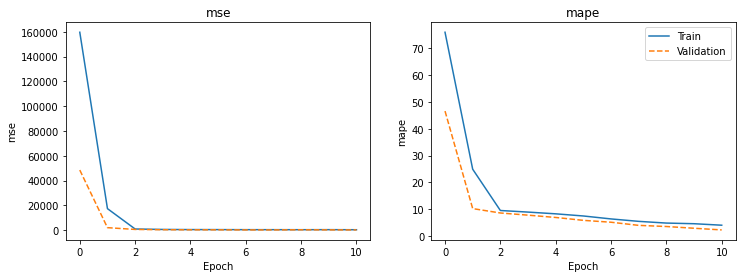

7/7 [==============================] - 0s 6ms/step - loss: 109.6756 - mse: 109.6756 - mape: 3.9859
Test MSE: 109.67564392089844 Test MAPE: 3.9858860969543457 Test Loss: 109.67564392089844
GOOG Correlation: (0.9989121826483924, 1.4947181618267656e-297)
AAPL Correlation: (0.9900850167988395, 3.1312951551510544e-191)


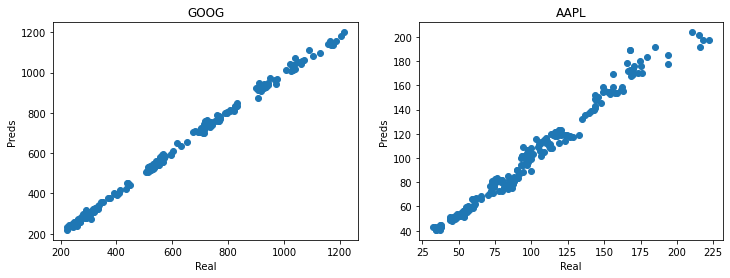

In [ ]:
trainer = RNN_Trainer(
    rnn='LSTM',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=50)
trainer.plot_history()
trainer.evaluate(x_test, y_test)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_30 (GRU)                (None, 512)               792576    
                                                                 
 dense_81 (Dense)            (None, 256)               131328    
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_82 (Dense)            (None, 128)               32896     
                                                                 
 dense_83 (Dense)            (None, 2)                 258       
                                                                 
Total params: 957,058
Trainable params: 957,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

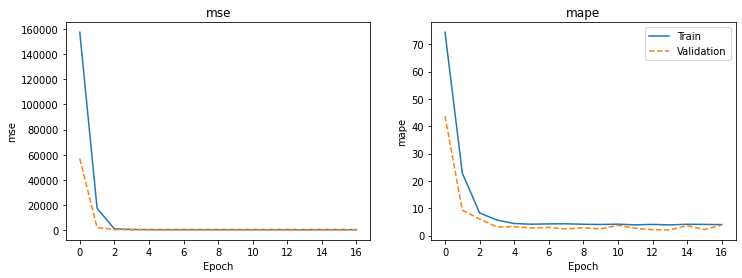

7/7 [==============================] - 0s 4ms/step - loss: 94.4819 - mse: 94.4819 - mape: 1.9911
Test MSE: 94.48188781738281 Test MAPE: 1.9911469221115112 Test Loss: 94.48188781738281


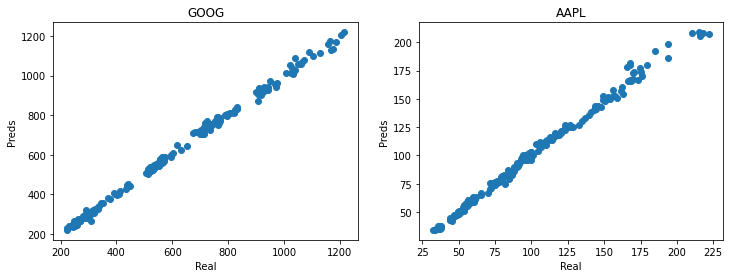

In [ ]:
trainer = RNN_Trainer(
    rnn='GRU',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=50)
trainer.plot_history()
trainer.evaluate(x_test, y_test)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_31 (SimpleRNN)   (None, 512)               263680    
                                                                 
 dense_84 (Dense)            (None, 256)               131328    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_85 (Dense)            (None, 128)               32896     
                                                                 
 dense_86 (Dense)            (None, 2)                 258       
                                                                 
Total params: 428,162
Trainable params: 428,162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

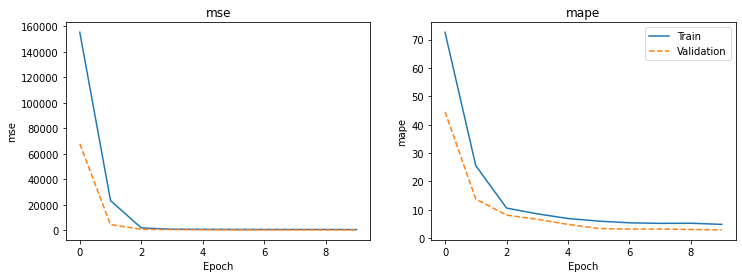

7/7 [==============================] - 0s 6ms/step - loss: 132.1198 - mse: 132.1198 - mape: 3.2975
Test MSE: 132.11981201171875 Test MAPE: 3.297455072402954 Test Loss: 132.11981201171875


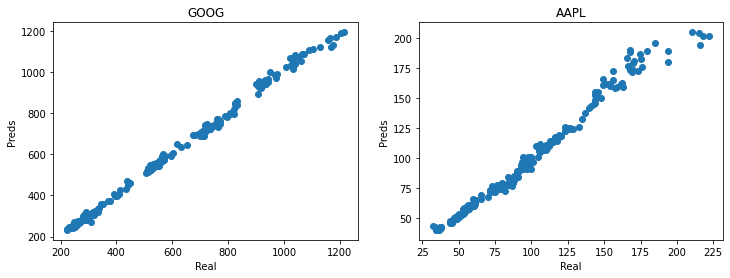

In [ ]:
trainer = RNN_Trainer(
    rnn='SimpleRNN',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)
print(trainer.model.summary())
trainer.train(x_train, y_train, batch_size=8, epochs=50)
trainer.plot_history()
trainer.evaluate(x_test, y_test)

# b)

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 512)               1054720   
                                                                 
 dense_135 (Dense)           (None, 256)               131328    
                                                                 
 dropout_42 (Dropout)        (None, 256)               0         
                                                                 
 dense_136 (Dense)           (None, 128)               32896     
                                                                 
 dense_137 (Dense)           (None, 2)                 258       
                                                                 
Total params: 1,219,202
Trainable params: 1,219,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [==================

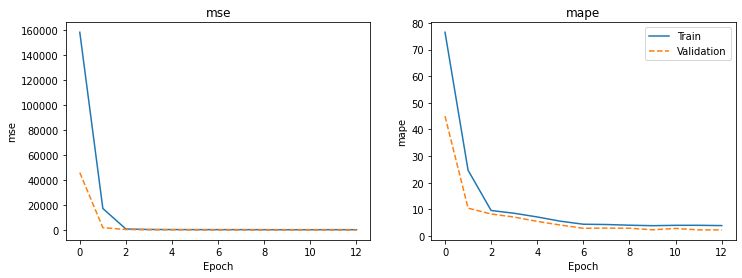

7/7 [==============================] - 0s 4ms/step - loss: 87.8111 - mse: 87.8111 - mape: 2.2195
Test MSE: 87.8111343383789 Test MAPE: 2.219520330429077 Test Loss: 87.8111343383789
GOOG Correlation: (0.9990796326872471, 1.3197843308536946e-305)
AAPL Correlation: (0.9962182328049571, 1.5035469165172692e-237)


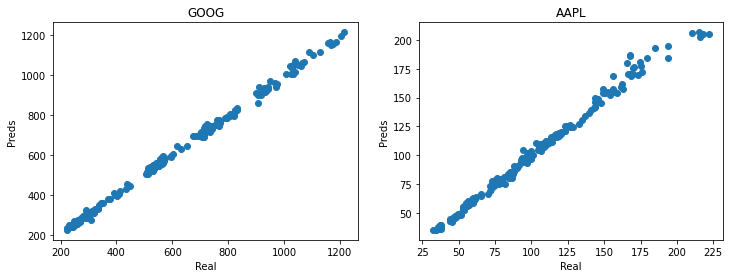

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_49 (GRU)                (None, 512)               792576    
                                                                 
 dense_138 (Dense)           (None, 256)               131328    
                                                                 
 dropout_43 (Dropout)        (None, 256)               0         
                                                                 
 dense_139 (Dense)           (None, 128)               32896     
                                                                 
 dense_140 (Dense)           (None, 2)                 258       
                                                                 
Total params: 957,058
Trainable params: 957,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

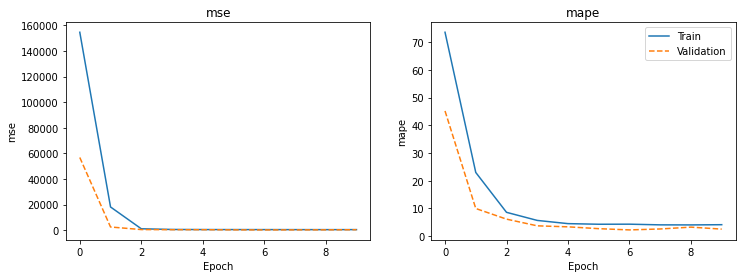

7/7 [==============================] - 0s 4ms/step - loss: 94.6385 - mse: 94.6385 - mape: 2.1212
Test MSE: 94.6385269165039 Test MAPE: 2.1212093830108643 Test Loss: 94.6385269165039
GOOG Correlation: (0.9989059450439703, 2.8186547035182282e-297)
AAPL Correlation: (0.9962420830754656, 7.459287529604588e-238)


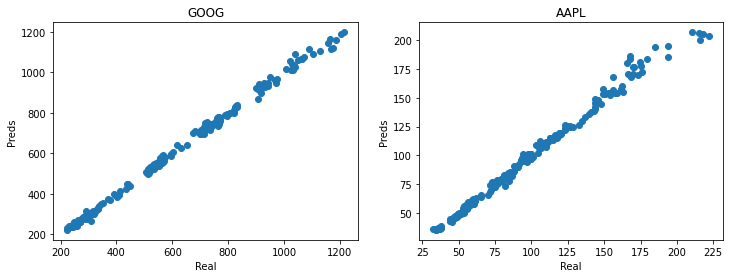

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_50 (SimpleRNN)   (None, 512)               263680    
                                                                 
 dense_141 (Dense)           (None, 256)               131328    
                                                                 
 dropout_44 (Dropout)        (None, 256)               0         
                                                                 
 dense_142 (Dense)           (None, 128)               32896     
                                                                 
 dense_143 (Dense)           (None, 2)                 258       
                                                                 
Total params: 428,162
Trainable params: 428,162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

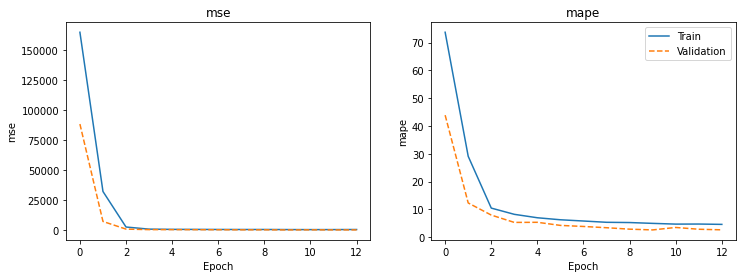

7/7 [==============================] - 0s 6ms/step - loss: 113.5016 - mse: 113.5016 - mape: 2.6636
Test MSE: 113.5016098022461 Test MAPE: 2.6636240482330322 Test Loss: 113.5016098022461
GOOG Correlation: (0.9988380704595848, 2.238963120539106e-294)
AAPL Correlation: (0.9949819793930612, 6.06410946439917e-224)


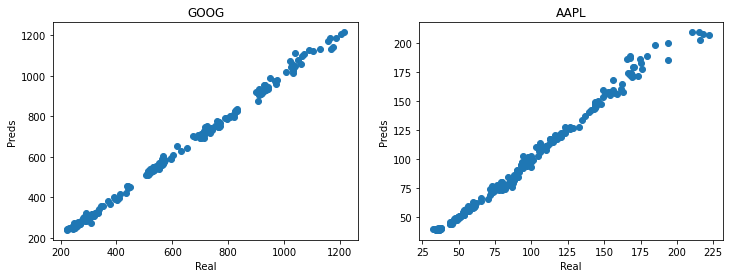

In [ ]:
for model_name in ["LSTM", "GRU", "SimpleRNN"]:
    trainer = RNN_Trainer(
        rnn=model_name,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss_function="mse"
    )
    print(trainer.model.summary())
    trainer.train(x_train, y_train, batch_size=8, epochs=50)
    trainer.plot_history()
    trainer.evaluate(x_test, y_test)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 512)               1054720   
                                                                 
 dense_144 (Dense)           (None, 256)               131328    
                                                                 
 dropout_45 (Dropout)        (None, 256)               0         
                                                                 
 dense_145 (Dense)           (None, 128)               32896     
                                                                 
 dense_146 (Dense)           (None, 2)                 258       
                                                                 
Total params: 1,219,202
Trainable params: 1,219,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [==================

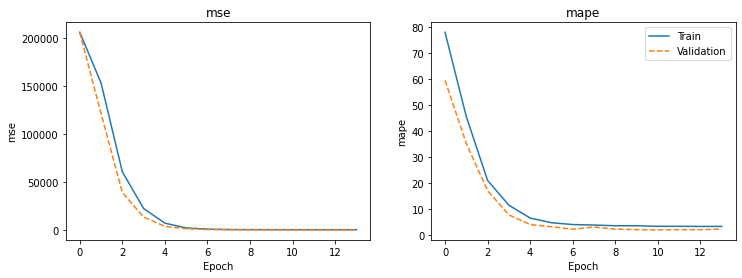

7/7 [==============================] - 0s 5ms/step - loss: 2.0752 - mse: 181.7442 - mape: 2.0752
Test MSE: 181.7442169189453 Test MAPE: 2.075216054916382 Test Loss: 2.075216054916382
GOOG Correlation: (0.9979924821111592, 4.900640091777378e-268)
AAPL Correlation: (0.9982331305651372, 3.470992871403205e-274)


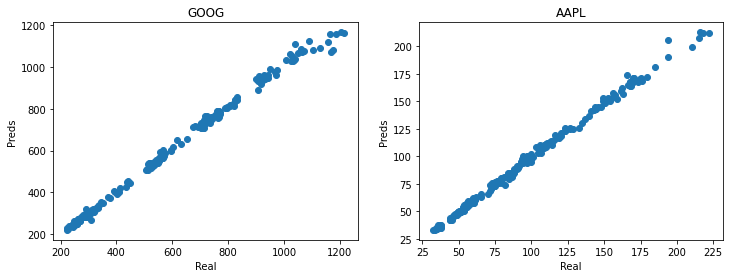

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_52 (GRU)                (None, 512)               792576    
                                                                 
 dense_147 (Dense)           (None, 256)               131328    
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 dense_148 (Dense)           (None, 128)               32896     
                                                                 
 dense_149 (Dense)           (None, 2)                 258       
                                                                 
Total params: 957,058
Trainable params: 957,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

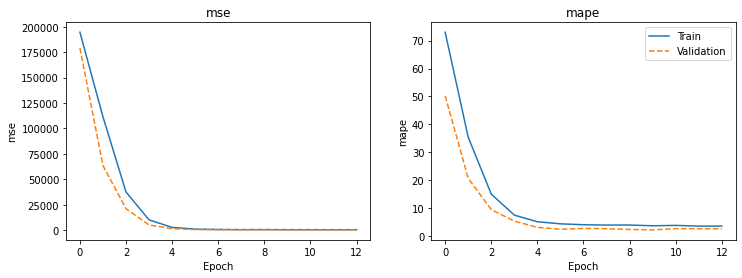

7/7 [==============================] - 0s 5ms/step - loss: 2.2768 - mse: 177.2651 - mape: 2.2768
Test MSE: 177.26513671875 Test MAPE: 2.276825428009033 Test Loss: 2.276825428009033
GOOG Correlation: (0.9980014251364148, 2.987001148312412e-268)
AAPL Correlation: (0.998388904985597, 1.2442213574146458e-278)


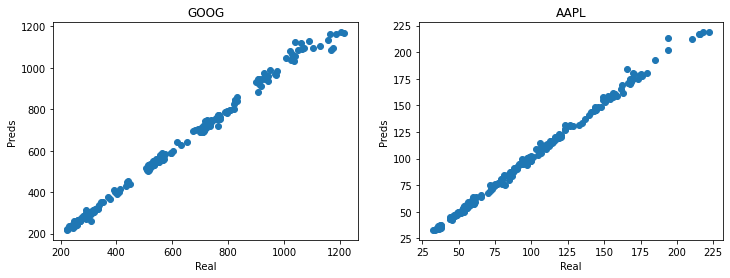

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_53 (SimpleRNN)   (None, 512)               263680    
                                                                 
 dense_150 (Dense)           (None, 256)               131328    
                                                                 
 dropout_47 (Dropout)        (None, 256)               0         
                                                                 
 dense_151 (Dense)           (None, 128)               32896     
                                                                 
 dense_152 (Dense)           (None, 2)                 258       
                                                                 
Total params: 428,162
Trainable params: 428,162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

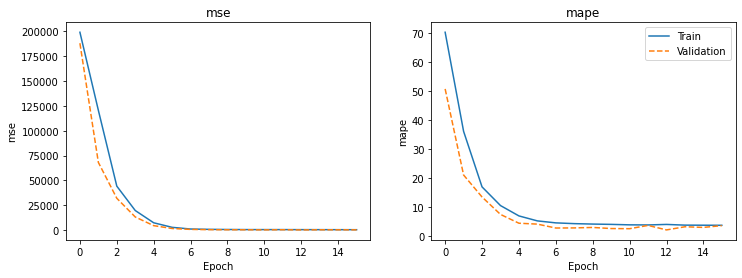

7/7 [==============================] - 0s 6ms/step - loss: 1.9732 - mse: 130.2357 - mape: 1.9732
Test MSE: 130.23570251464844 Test MAPE: 1.97318434715271 Test Loss: 1.97318434715271
GOOG Correlation: (0.9983949201551864, 8.217113431907953e-279)
AAPL Correlation: (0.998118338160735, 3.733825942314088e-271)


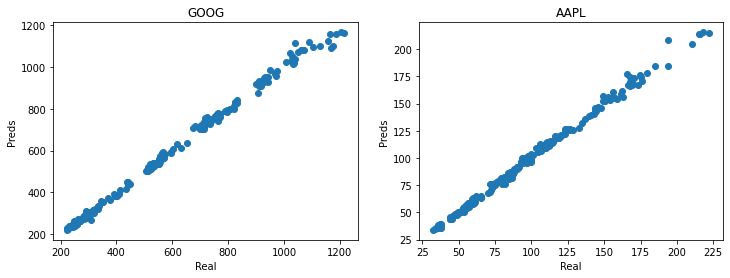

In [ ]:
for model_name in ["LSTM", "GRU", "SimpleRNN"]:
    trainer = RNN_Trainer(
        rnn=model_name,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss_function="mape"
    )
    print(trainer.model.summary())
    trainer.train(x_train, y_train, batch_size=8, epochs=50)
    trainer.plot_history()
    trainer.evaluate(x_test, y_test)

# g)

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 512)               1054720   
                                                                 
 dense_153 (Dense)           (None, 256)               131328    
                                                                 
 dropout_48 (Dropout)        (None, 256)               0         
                                                                 
 dense_154 (Dense)           (None, 128)               32896     
                                                                 
 dense_155 (Dense)           (None, 2)                 258       
                                                                 
Total params: 1,219,202
Trainable params: 1,219,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [==================

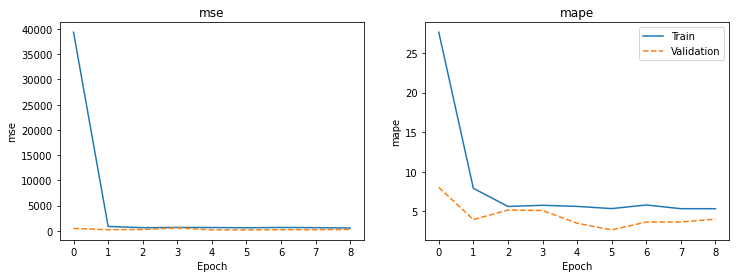

7/7 [==============================] - 0s 5ms/step - loss: 6.9835 - mse: 137.3946 - mape: 2.3666
Test MSE: 137.39463806152344 Test MAPE: 2.3665735721588135 Test Loss: 6.983466148376465
GOOG Correlation: (0.9985275520600588, 5.756633382657193e-283)
AAPL Correlation: (0.9960641142315309, 1.2561912922895692e-235)


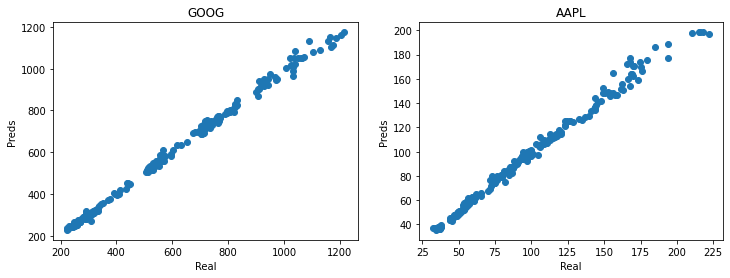

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_55 (GRU)                (None, 512)               792576    
                                                                 
 dense_156 (Dense)           (None, 256)               131328    
                                                                 
 dropout_49 (Dropout)        (None, 256)               0         
                                                                 
 dense_157 (Dense)           (None, 128)               32896     
                                                                 
 dense_158 (Dense)           (None, 2)                 258       
                                                                 
Total params: 957,058
Trainable params: 957,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

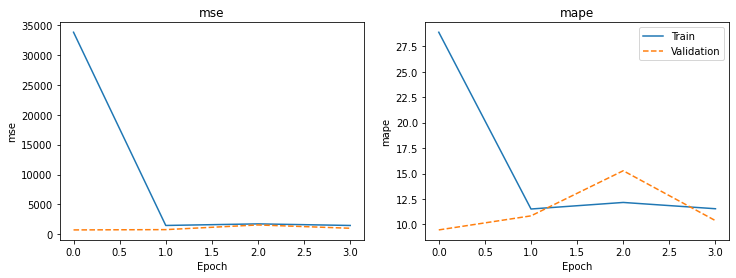

7/7 [==============================] - 0s 5ms/step - loss: 17.7269 - mse: 578.2213 - mape: 9.3393
Test MSE: 578.2213134765625 Test MAPE: 9.339320182800293 Test Loss: 17.726863861083984
GOOG Correlation: (0.9956924714431555, 2.753280938043531e-231)
AAPL Correlation: (0.926955029994091, 1.7384776454541305e-96)


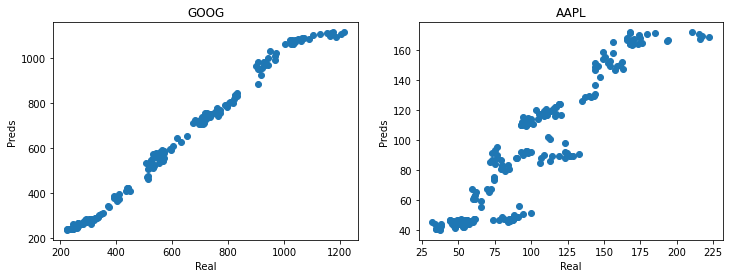

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_56 (SimpleRNN)   (None, 512)               263680    
                                                                 
 dense_159 (Dense)           (None, 256)               131328    
                                                                 
 dropout_50 (Dropout)        (None, 256)               0         
                                                                 
 dense_160 (Dense)           (None, 128)               32896     
                                                                 
 dense_161 (Dense)           (None, 2)                 258       
                                                                 
Total params: 428,162
Trainable params: 428,162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

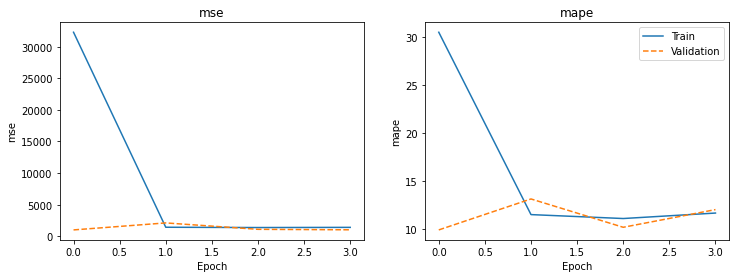

7/7 [==============================] - 0s 6ms/step - loss: 18.5627 - mse: 679.3157 - mape: 9.6632
Test MSE: 679.3157348632812 Test MAPE: 9.663232803344727 Test Loss: 18.562726974487305
GOOG Correlation: (0.9963282056544253, 5.716104083579422e-239)
AAPL Correlation: (0.9341881783338786, 2.4583883024206172e-101)


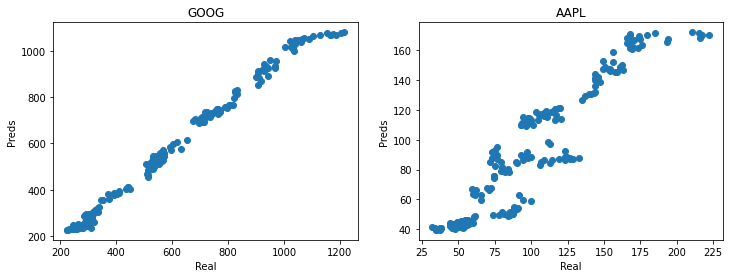

In [ ]:
for model_name in ["LSTM", "GRU", "SimpleRNN"]:
    trainer = RNN_Trainer(
        rnn=model_name,
        optimizer='adam',
        loss_function="mae"
    )
    print(trainer.model.summary())
    trainer.train(x_train, y_train, batch_size=8, epochs=50)
    trainer.plot_history()
    trainer.evaluate(x_test, y_test)

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 512)               1054720   
                                                                 
 dense_162 (Dense)           (None, 256)               131328    
                                                                 
 dropout_51 (Dropout)        (None, 256)               0         
                                                                 
 dense_163 (Dense)           (None, 128)               32896     
                                                                 
 dense_164 (Dense)           (None, 2)                 258       
                                                                 
Total params: 1,219,202
Trainable params: 1,219,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [==================

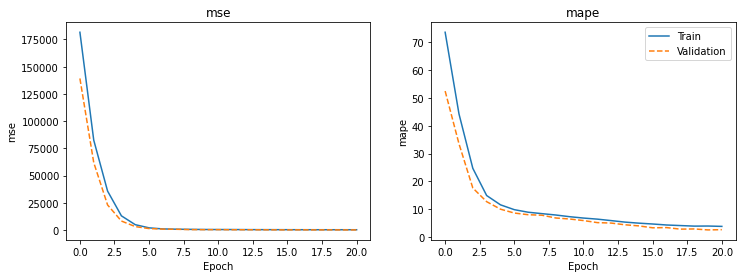

7/7 [==============================] - 0s 5ms/step - loss: 6.6430 - mse: 115.5106 - mape: 2.6089
Test MSE: 115.51056671142578 Test MAPE: 2.6089134216308594 Test Loss: 6.643002986907959
GOOG Correlation: (0.9986795035336421, 3.2596267978564183e-288)
AAPL Correlation: (0.9949679450926086, 8.261697684298086e-224)


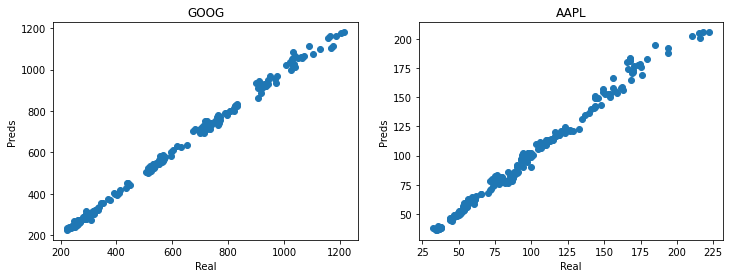

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_58 (GRU)                (None, 512)               792576    
                                                                 
 dense_165 (Dense)           (None, 256)               131328    
                                                                 
 dropout_52 (Dropout)        (None, 256)               0         
                                                                 
 dense_166 (Dense)           (None, 128)               32896     
                                                                 
 dense_167 (Dense)           (None, 2)                 258       
                                                                 
Total params: 957,058
Trainable params: 957,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

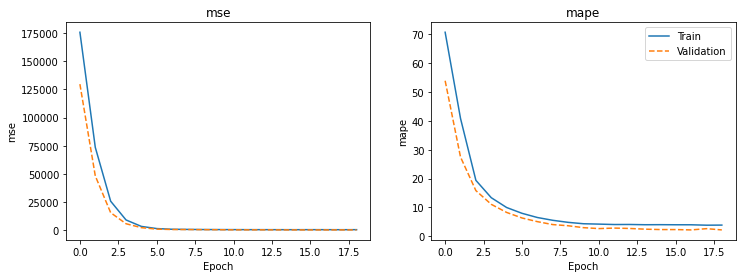

7/7 [==============================] - 0s 4ms/step - loss: 5.9232 - mse: 96.9886 - mape: 2.0881
Test MSE: 96.98856353759766 Test MAPE: 2.088120937347412 Test Loss: 5.923176288604736
GOOG Correlation: (0.998888621523015, 1.6105242042305695e-296)
AAPL Correlation: (0.995988617550334, 1.030839275878535e-234)


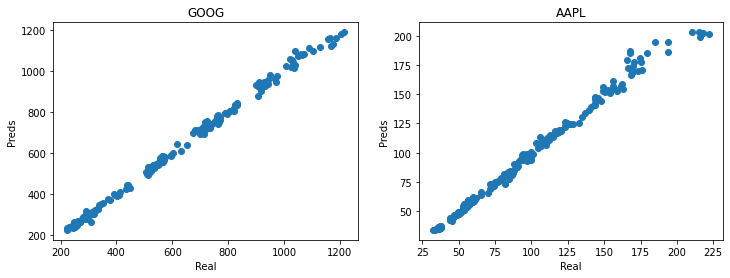

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_59 (SimpleRNN)   (None, 512)               263680    
                                                                 
 dense_168 (Dense)           (None, 256)               131328    
                                                                 
 dropout_53 (Dropout)        (None, 256)               0         
                                                                 
 dense_169 (Dense)           (None, 128)               32896     
                                                                 
 dense_170 (Dense)           (None, 2)                 258       
                                                                 
Total params: 428,162
Trainable params: 428,162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

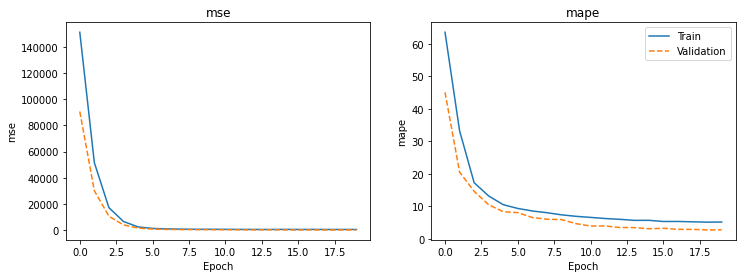

7/7 [==============================] - 0s 6ms/step - loss: 6.9546 - mse: 124.9332 - mape: 2.7234
Test MSE: 124.93323516845703 Test MAPE: 2.723388433456421 Test Loss: 6.954575538635254
GOOG Correlation: (0.9985926206624389, 3.827504021098407e-285)
AAPL Correlation: (0.9939237425048109, 9.59756313285314e-215)


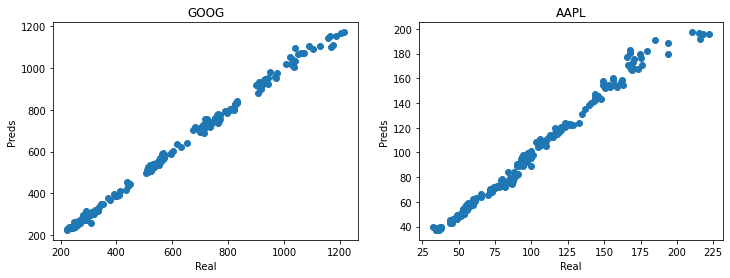

In [ ]:
for model_name in ["LSTM", "GRU", "SimpleRNN"]:
    trainer = RNN_Trainer(
        rnn=model_name,
        optimizer='adagrad',
        loss_function="mae"
    )
    print(trainer.model.summary())
    trainer.train(x_train, y_train, batch_size=8, epochs=50)
    trainer.plot_history()
    trainer.evaluate(x_test, y_test)

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 512)               1054720   
                                                                 
 dense_171 (Dense)           (None, 256)               131328    
                                                                 
 dropout_54 (Dropout)        (None, 256)               0         
                                                                 
 dense_172 (Dense)           (None, 128)               32896     
                                                                 
 dense_173 (Dense)           (None, 2)                 258       
                                                                 
Total params: 1,219,202
Trainable params: 1,219,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [==================

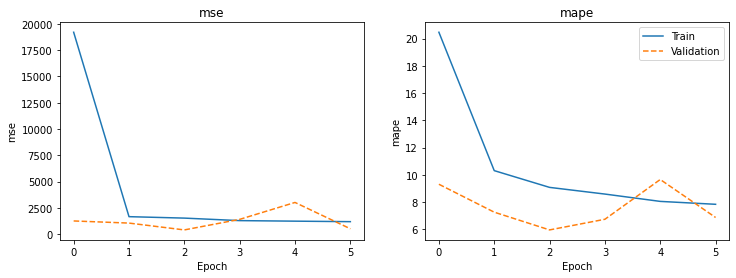

7/7 [==============================] - 0s 4ms/step - loss: 12.2755 - mse: 297.6684 - mape: 6.1080
Test MSE: 297.6684265136719 Test MAPE: 6.107975006103516 Test Loss: 12.275542259216309
GOOG Correlation: (0.9970051432029166, 8.900154679304807e-249)
AAPL Correlation: (0.988032690025078, 3.2815784352482756e-182)


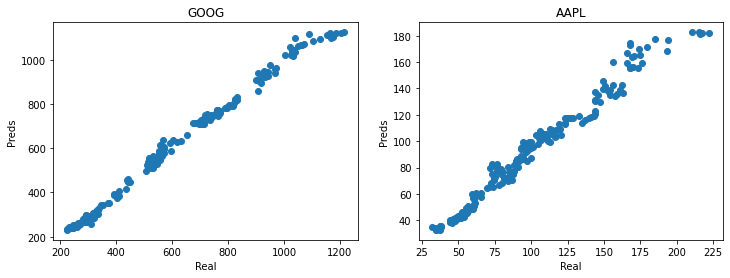

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_61 (GRU)                (None, 512)               792576    
                                                                 
 dense_174 (Dense)           (None, 256)               131328    
                                                                 
 dropout_55 (Dropout)        (None, 256)               0         
                                                                 
 dense_175 (Dense)           (None, 128)               32896     
                                                                 
 dense_176 (Dense)           (None, 2)                 258       
                                                                 
Total params: 957,058
Trainable params: 957,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

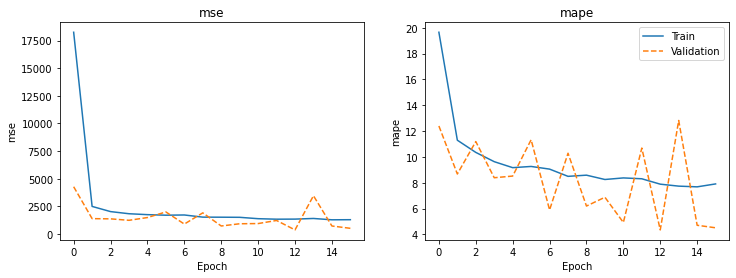

7/7 [==============================] - 0s 4ms/step - loss: 11.4948 - mse: 276.7355 - mape: 4.4006
Test MSE: 276.7355041503906 Test MAPE: 4.400625705718994 Test Loss: 11.494772911071777
GOOG Correlation: (0.9974244564571597, 4.875759650850061e-256)
AAPL Correlation: (0.9931788528706351, 3.4596302499251107e-209)


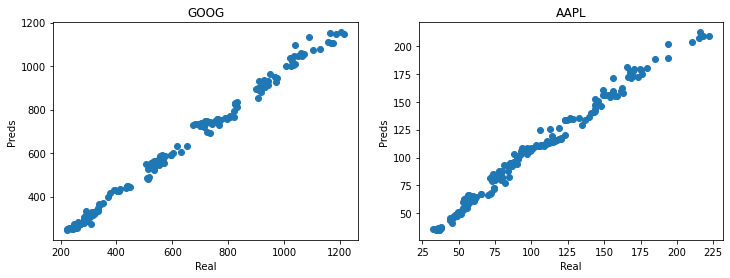

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_62 (SimpleRNN)   (None, 512)               263680    
                                                                 
 dense_177 (Dense)           (None, 256)               131328    
                                                                 
 dropout_56 (Dropout)        (None, 256)               0         
                                                                 
 dense_178 (Dense)           (None, 128)               32896     
                                                                 
 dense_179 (Dense)           (None, 2)                 258       
                                                                 
Total params: 428,162
Trainable params: 428,162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

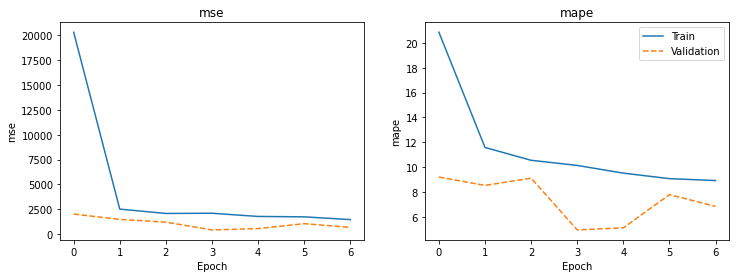

7/7 [==============================] - 0s 7ms/step - loss: 12.8102 - mse: 352.5565 - mape: 4.7562
Test MSE: 352.5564880371094 Test MAPE: 4.756206512451172 Test Loss: 12.810212135314941
GOOG Correlation: (0.9960867886882964, 6.623294049347945e-236)
AAPL Correlation: (0.9899198380030665, 1.9421293662504796e-190)


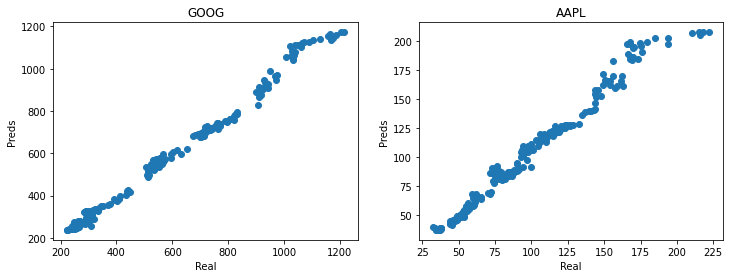

In [ ]:
for model_name in ["LSTM", "GRU", "SimpleRNN"]:
    trainer = RNN_Trainer(
        rnn=model_name,
        optimizer='rmsprop',
        loss_function="mae"
    )
    print(trainer.model.summary())
    trainer.train(x_train, y_train, batch_size=8, epochs=50)
    trainer.plot_history()
    trainer.evaluate(x_test, y_test)

# d)

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 512)               1054720   
                                                                 
 dense_180 (Dense)           (None, 256)               131328    
                                                                 
 dropout_57 (Dropout)        (None, 256)               0         
                                                                 
 dense_181 (Dense)           (None, 128)               32896     
                                                                 
 dense_182 (Dense)           (None, 2)                 258       
                                                                 
Total params: 1,219,202
Trainable params: 1,219,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [==================

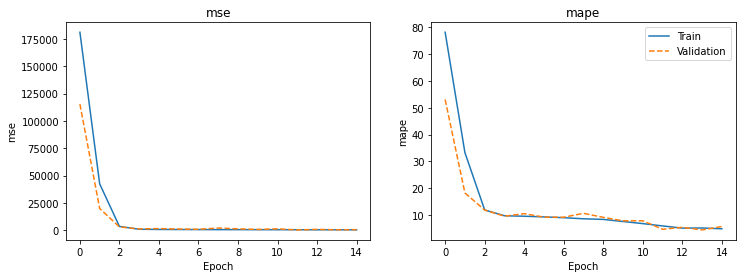

7/7 [==============================] - 0s 5ms/step - loss: 9.5170 - mse: 174.4867 - mape: 4.3767
Test MSE: 174.4866943359375 Test MAPE: 4.376711845397949 Test Loss: 9.516950607299805
GOOG Correlation: (0.9984978984347899, 5.2559824866183586e-282)
AAPL Correlation: (0.9858953035871791, 2.437350731629186e-174)


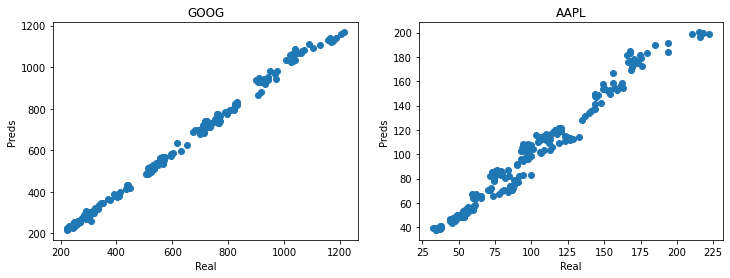

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_64 (GRU)                (None, 512)               792576    
                                                                 
 dense_183 (Dense)           (None, 256)               131328    
                                                                 
 dropout_58 (Dropout)        (None, 256)               0         
                                                                 
 dense_184 (Dense)           (None, 128)               32896     
                                                                 
 dense_185 (Dense)           (None, 2)                 258       
                                                                 
Total params: 957,058
Trainable params: 957,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

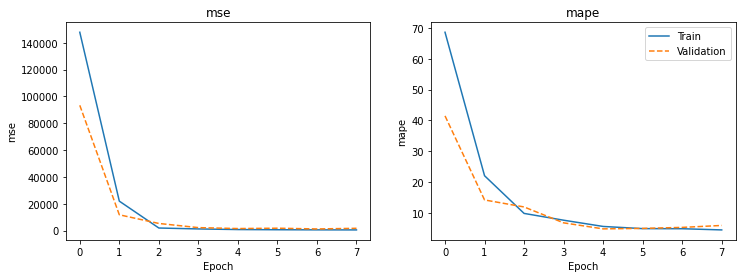

7/7 [==============================] - 0s 5ms/step - loss: 15.0844 - mse: 872.5463 - mape: 4.2659
Test MSE: 872.5462646484375 Test MAPE: 4.265923500061035 Test Loss: 15.084434509277344
GOOG Correlation: (0.9957294896482979, 1.0584194726516225e-231)
AAPL Correlation: (0.9875299646317958, 3.074730487948708e-180)


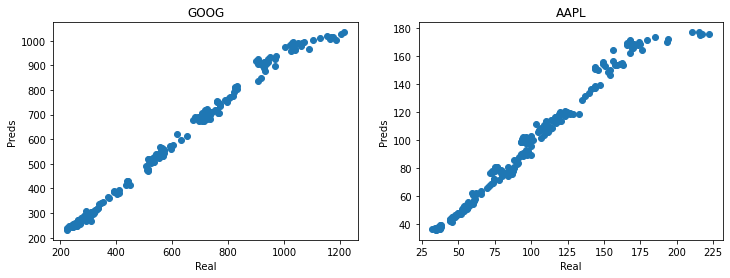

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_65 (SimpleRNN)   (None, 512)               263680    
                                                                 
 dense_186 (Dense)           (None, 256)               131328    
                                                                 
 dropout_59 (Dropout)        (None, 256)               0         
                                                                 
 dense_187 (Dense)           (None, 128)               32896     
                                                                 
 dense_188 (Dense)           (None, 2)                 258       
                                                                 
Total params: 428,162
Trainable params: 428,162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

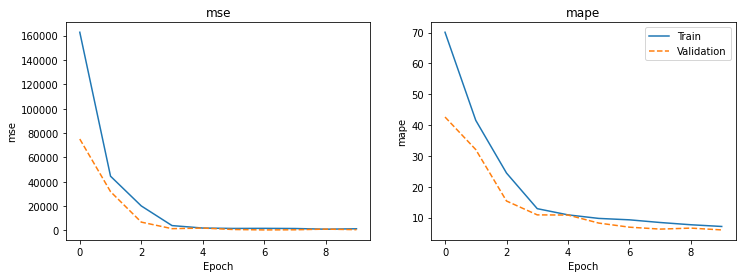

7/7 [==============================] - 0s 6ms/step - loss: 12.3845 - mse: 305.9987 - mape: 6.4862
Test MSE: 305.99871826171875 Test MAPE: 6.4861907958984375 Test Loss: 12.384493827819824
GOOG Correlation: (0.9977895702231283, 2.124048526520486e-263)
AAPL Correlation: (0.9686065814811894, 3.4892066523020906e-136)


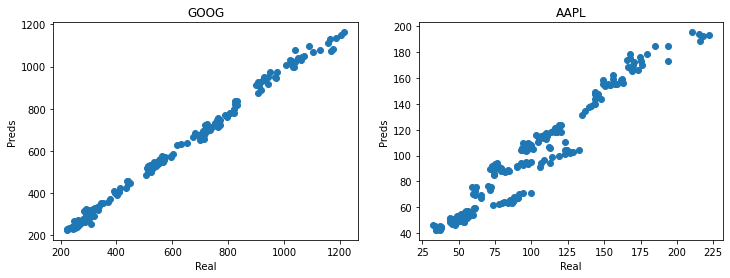

In [ ]:
for model_name in ["LSTM", "GRU", "SimpleRNN"]:
    trainer = RNN_Trainer(
        rnn=model_name,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss_function="mae",
        dropout=0.05
    )
    print(trainer.model.summary())
    trainer.train(x_train, y_train, batch_size=8, epochs=50)
    trainer.plot_history()
    trainer.evaluate(x_test, y_test)

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 512)               1054720   
                                                                 
 dense_189 (Dense)           (None, 256)               131328    
                                                                 
 dropout_60 (Dropout)        (None, 256)               0         
                                                                 
 dense_190 (Dense)           (None, 128)               32896     
                                                                 
 dense_191 (Dense)           (None, 2)                 258       
                                                                 
Total params: 1,219,202
Trainable params: 1,219,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [==================

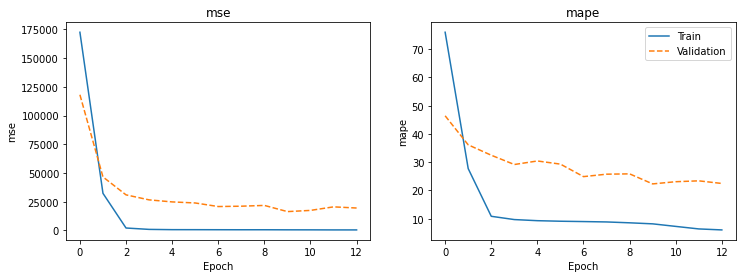

7/7 [==============================] - 0s 5ms/step - loss: 80.6268 - mse: 13623.5967 - mape: 21.6600
Test MSE: 13623.5966796875 Test MAPE: 21.659988403320312 Test Loss: 80.62678527832031
GOOG Correlation: (0.994830511620704, 1.6321159137972743e-222)
AAPL Correlation: (0.9396051248967967, 2.4113531053216488e-105)


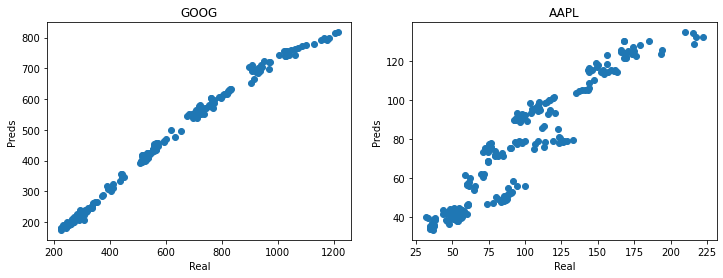

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_67 (GRU)                (None, 512)               792576    
                                                                 
 dense_192 (Dense)           (None, 256)               131328    
                                                                 
 dropout_61 (Dropout)        (None, 256)               0         
                                                                 
 dense_193 (Dense)           (None, 128)               32896     
                                                                 
 dense_194 (Dense)           (None, 2)                 258       
                                                                 
Total params: 957,058
Trainable params: 957,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

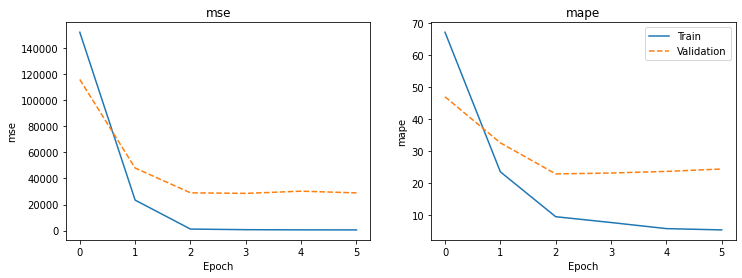

7/7 [==============================] - 0s 4ms/step - loss: 86.5835 - mse: 23065.4121 - mape: 20.6820
Test MSE: 23065.412109375 Test MAPE: 20.68195915222168 Test Loss: 86.58348846435547
GOOG Correlation: (0.9619041513295417, 5.124363938842617e-127)
AAPL Correlation: (0.8638098424059395, 4.965376092127247e-68)


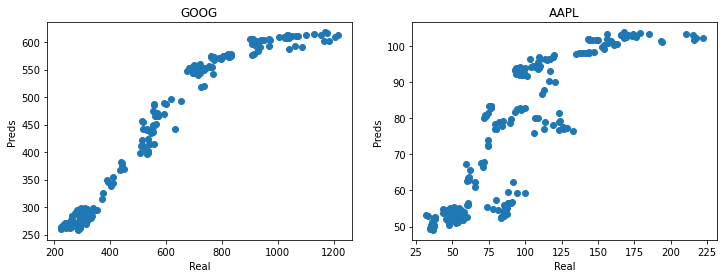

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_68 (SimpleRNN)   (None, 512)               263680    
                                                                 
 dense_195 (Dense)           (None, 256)               131328    
                                                                 
 dropout_62 (Dropout)        (None, 256)               0         
                                                                 
 dense_196 (Dense)           (None, 128)               32896     
                                                                 
 dense_197 (Dense)           (None, 2)                 258       
                                                                 
Total params: 428,162
Trainable params: 428,162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

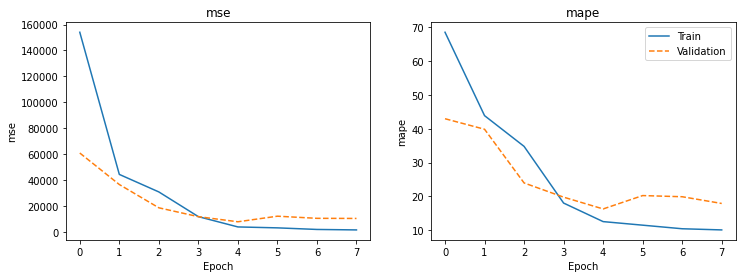

7/7 [==============================] - 0s 6ms/step - loss: 53.1834 - mse: 6227.0835 - mape: 15.0253
Test MSE: 6227.08349609375 Test MAPE: 15.025291442871094 Test Loss: 53.183387756347656
GOOG Correlation: (0.9941402473960737, 1.7309585196567663e-216)
AAPL Correlation: (0.9336892262141976, 5.527684964038652e-101)


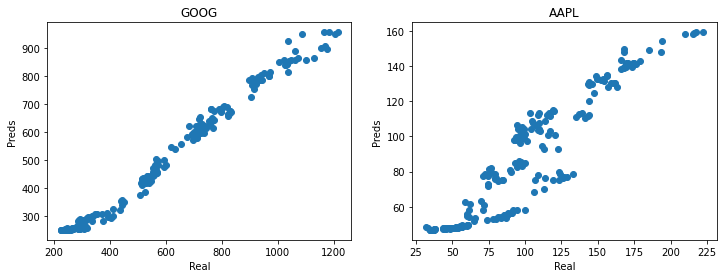

In [ ]:
for model_name in ["LSTM", "GRU", "SimpleRNN"]:
    trainer = RNN_Trainer(
        rnn=model_name,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss_function="mae",
        dropout=0.2
    )
    print(trainer.model.summary())
    trainer.train(x_train, y_train, batch_size=8, epochs=50)
    trainer.plot_history()
    trainer.evaluate(x_test, y_test)

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 512)               1054720   
                                                                 
 dense_198 (Dense)           (None, 256)               131328    
                                                                 
 dropout_63 (Dropout)        (None, 256)               0         
                                                                 
 dense_199 (Dense)           (None, 128)               32896     
                                                                 
 dense_200 (Dense)           (None, 2)                 258       
                                                                 
Total params: 1,219,202
Trainable params: 1,219,202
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [==================

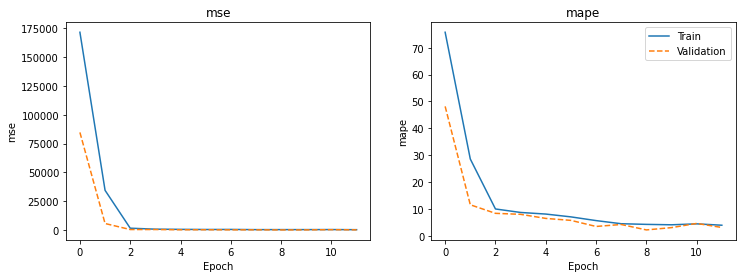

7/7 [==============================] - 0s 5ms/step - loss: 5.8040 - mse: 93.5827 - mape: 1.9985
Test MSE: 93.58267974853516 Test MAPE: 1.998477816581726 Test Loss: 5.803983211517334
GOOG Correlation: (0.9989428827009631, 6.240874154115458e-299)
AAPL Correlation: (0.9975643270072796, 9.991181326324029e-259)


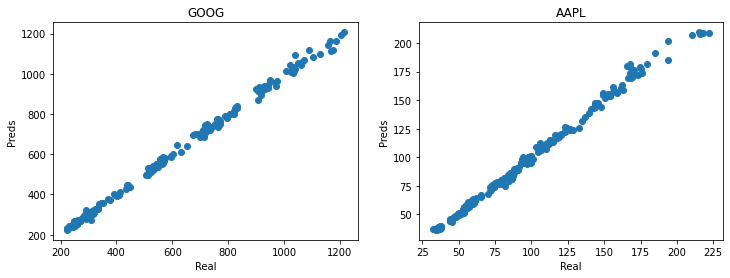

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_70 (GRU)                (None, 512)               792576    
                                                                 
 dense_201 (Dense)           (None, 256)               131328    
                                                                 
 dropout_64 (Dropout)        (None, 256)               0         
                                                                 
 dense_202 (Dense)           (None, 128)               32896     
                                                                 
 dense_203 (Dense)           (None, 2)                 258       
                                                                 
Total params: 957,058
Trainable params: 957,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

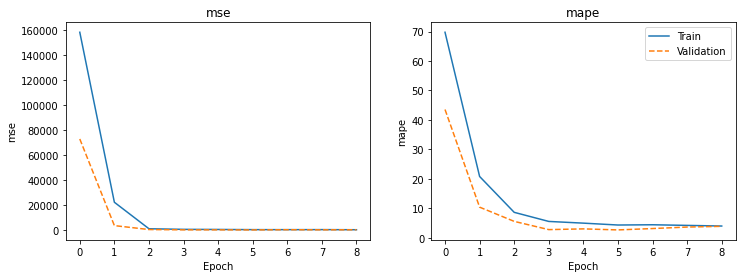

7/7 [==============================] - 0s 4ms/step - loss: 6.8832 - mse: 125.4335 - mape: 2.4508
Test MSE: 125.43354034423828 Test MAPE: 2.450753688812256 Test Loss: 6.883213996887207
GOOG Correlation: (0.9988181227144441, 1.479627027333416e-293)
AAPL Correlation: (0.9971168501559835, 1.3169334695606462e-250)


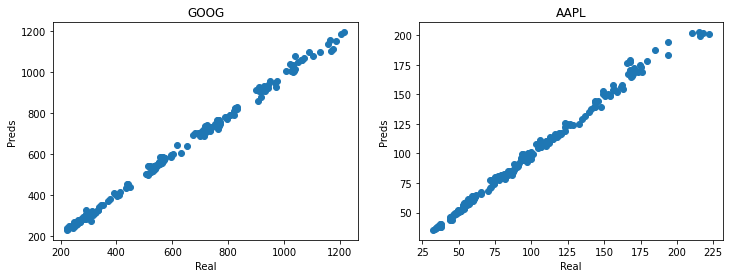

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_71 (SimpleRNN)   (None, 512)               263680    
                                                                 
 dense_204 (Dense)           (None, 256)               131328    
                                                                 
 dropout_65 (Dropout)        (None, 256)               0         
                                                                 
 dense_205 (Dense)           (None, 128)               32896     
                                                                 
 dense_206 (Dense)           (None, 2)                 258       
                                                                 
Total params: 428,162
Trainable params: 428,162
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
226/226 [======================

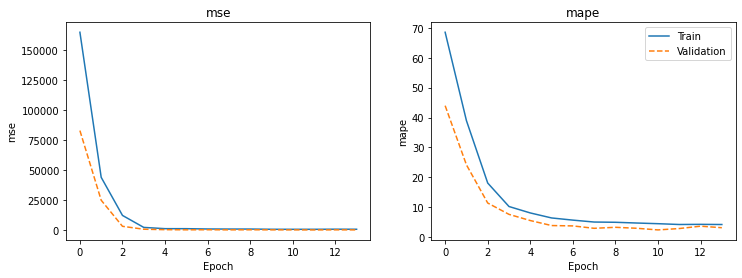

7/7 [==============================] - 0s 6ms/step - loss: 7.2917 - mse: 168.6304 - mape: 2.5079
Test MSE: 168.63035583496094 Test MAPE: 2.507930040359497 Test Loss: 7.291733741760254
GOOG Correlation: (0.9980656063049835, 8.003313673954992e-270)
AAPL Correlation: (0.9974353241376868, 3.051111888006413e-256)


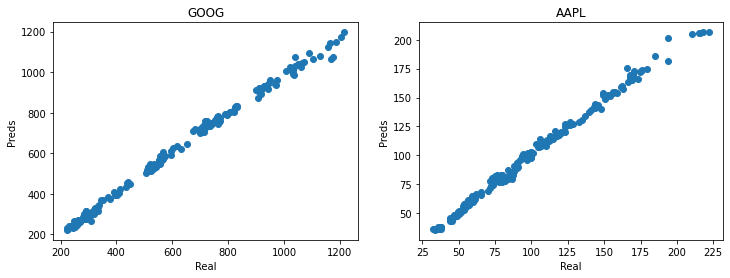

In [ ]:
for model_name in ["LSTM", "GRU", "SimpleRNN"]:
    trainer = RNN_Trainer(
        rnn=model_name,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss_function="mae",
        dropout=0.01
    )
    print(trainer.model.summary())
    trainer.train(x_train, y_train, batch_size=8, epochs=50)
    trainer.plot_history()
    trainer.evaluate(x_test, y_test)